In [1]:
from helpers import *
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
#Load data
articles, categories, links, paths_finished, paths_unfinished, paths_all, shortest_path_distance = load_data()

#Remove the paths that has only a starting point and are not of our interest
paths_unfinished = paths_unfinished[paths_unfinished.pathLength > 1]

#Create the graphs of interest
G_paths, G_links = get_graphs(paths_all,links)
G_paths_finished, _ = get_graphs(paths_finished,links)
G_paths_unfinished, _ = get_graphs(paths_unfinished,links)

In [148]:
paths_all

,path_id,hashedIpAddress,timestamp,durationInSec,path,pathLength,target,type
timestamp,,,,,,,,
1297740409,0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,9,African_slave_trade,finished
1344753412,1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,5,African_slave_trade,finished
1349298640,2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,8,African_slave_trade,finished
1265613925,3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,4,Greece,finished
1366730828,4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,7,John_F._Kennedy,finished
...,...,...,...,...,...,...,...,...
1389787605,76188,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...,8,Cholera,restart
1389787697,76189,232f992e57d43e8d,1389787697,6,Modern_history,1,Hollandic,restart
1389798400,76190,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture;Popul...,5,The_Beatles,timeout


## Preprocess the DataFrame

In [3]:
#Add an extra column indicating if the game is the player's last game
paths_all.index = paths_all['timestamp']
group = paths_all.groupby('hashedIpAddress')
processed_paths_all_raw = pd.DataFrame()
for key, df in group:
    df['bh_type']= 'continue'
    df.loc[df.index.max(),'bh_type'] = 'quit'
    processed_paths_all_raw = pd.concat([processed_paths_all_raw,df])

In [165]:
null_address = list(set(paths_all['path_id']) - set(processed_paths_all_raw['path_id']))
null_entries = paths_all[paths_all['path_id'].isin(null_address)]
null_entries['bh_type'] = 'continue'
processed_paths_all_raw = pd.concat([processed_paths_all_raw,null_entries])

C:\Users\26553\AppData\Local\Temp\ipykernel_19500\835217931.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_entries['bh_type'] = 'continue'


In [173]:
#Parse the path string in df, and calculate the distance to target for each node the player has been to 
def _parse_withdraw(path):
    page_stack = []
    parsed_path = []
    time_withdraw = 0
    for node in path:
        if node != '<':
            page_stack.append(node)
        else:
            page_stack.pop()
            time_withdraw = time_withdraw +1
        parsed_path.append(page_stack[-1])
    return [parsed_path, time_withdraw]


processed_paths_all = processed_paths_all_raw[['path_id','hashedIpAddress','path','target','type','bh_type','pathLength']].copy()

#Parse the path string into a list and find the last visited node
processed_paths_all['path'] = processed_paths_all['path'].apply(lambda p: p.split(';'))
processed_paths_all['path'] = processed_paths_all['path'].apply(lambda pl: _parse_withdraw(pl)[0])
processed_paths_all['n_withdraws'] = processed_paths_all['path'].apply(lambda pl: _parse_withdraw(pl)[1])
processed_paths_all['end_node'] = processed_paths_all['path'].apply(lambda p: p[-1])

In [174]:
#Calculating distance to the target for each node visited in the game
def graph_dist(Graph, current_node, target_node):
    try:
        return nx.shortest_path_length(Graph,current_node,target_node)
    except:
        return np.inf

    
processed_paths_all['M_path_dist_to_target'] = processed_paths_all[['path','target']].apply(lambda r: [graph_dist(G_links, r[0][i], r[1]) for i in range(len(r[0]))], axis = 1)
processed_paths_all['P_path_dist_to_target'] = processed_paths_all[['path','target']].apply(lambda r: [graph_dist(G_paths, r[0][i], r[1]) for i in range(len(r[0]))], axis = 1)
processed_paths_all['M_dist_to_target'] = processed_paths_all[['end_node','target']].apply(lambda r: graph_dist(G_links, r[0], r[1]), axis = 1)
processed_paths_all['P_dist_to_target'] = processed_paths_all[['end_node','target']].apply(lambda r: graph_dist(G_paths, r[0], r[1]), axis = 1)

processed_paths_all['Pf_path_dist_to_target'] = processed_paths_all[['path','target']].apply(lambda r: [graph_dist(G_paths_finished, r[0][i], r[1]) for i in range(len(r[0]))], axis = 1)
processed_paths_all['Pu_path_dist_to_target'] = processed_paths_all[['path','target']].apply(lambda r: [graph_dist(G_paths_unfinished, r[0][i], r[1]) for i in range(len(r[0]))], axis = 1)

In [175]:
def count_forward_neutral_backward(path_dist):
    count = [0,0,0]
    for i in range(len(path_dist)-1):
        move = path_dist[i]-path_dist[i+1]
        if move>0:
            count[0] = count[0] + 1
        elif move<0:
            count[2] = count[2] + 1
        else:
            count[1] = count[1] + 1
    return count

processed_paths_all['n_M_forward'] = processed_paths_all['M_path_dist_to_target'].apply(lambda d: count_forward_neutral_backward(d)[0])
processed_paths_all['n_M_neutral'] = processed_paths_all['M_path_dist_to_target'].apply(lambda d: count_forward_neutral_backward(d)[1])
processed_paths_all['n_M_backward'] = processed_paths_all['M_path_dist_to_target'].apply(lambda d: count_forward_neutral_backward(d)[2])

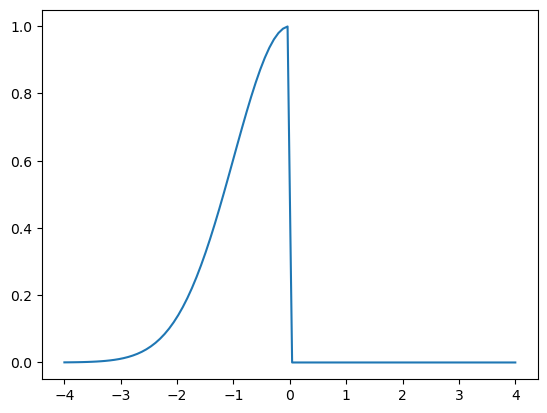

In [176]:
def gaussian_kernel(x,sigma,mu):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.))) if x <= mu else 0

def count_path_score_gaussian(p, sigma, mu_shift = 0):
    diff = [p[i]-p[i+1] for i in range(len(p)-1)]
    _diff = [i if i != -np.inf else -1 for i in diff]
    score = np.sum([diff[i]*gaussian_kernel(i,sigma,len(diff)-1 + mu_shift) for i in range(len(diff))])
    return score

#Plot the convolution kernel
x = np.linspace(-4,4,100)
y = [gaussian_kernel(i,1,0) for i in x]
plt.plot(x,y)

In [177]:
sigma = processed_paths_all['pathLength'].mean()/2
processed_paths_all['score'] = processed_paths_all['M_path_dist_to_target'].apply(lambda d: count_path_score_gaussian(d,sigma, -1))

## Making dataset from each disicion made in the game

In [137]:
def break_path(p):
    s = {'path':[], 'finished':[]}
    for i in range(2,len(p)+1):
        s['path'].append(p[:i])
        s['finished'].append(1 if i==len(p) else 0)
    return pd.DataFrame(s)

dataset = pd.DataFrame()
count = 0
for p in list(processed_paths_all['M_path_dist_to_target']):
    dataset = pd.concat([dataset, break_path(p)])
    count = count +1
    if count % 3000 == 0:
        print(count)

from itertools import chain
dataset['type'] = list(chain(*list(processed_paths_all[['pathLength','type']].apply(lambda r: [str(r[1])]*(r[0]-1),axis = 1))))

3000
6000
9000
12000
15000
18000
21000
24000
27000
30000
33000
36000
39000
42000
45000
48000
51000
54000
57000
60000
63000
66000
69000
72000
75000


In [138]:
#Calculate path score for dataset
dataset['score'] = dataset['path'].apply(lambda d: count_path_score_gaussian(d,sigma, 0))

In [139]:
dataset['pathLength'] = dataset['path'].apply(lambda d: len(d))
dataset['Est_pathLength'] = dataset['path'].apply(lambda d: len(d) + d[-1])

## Find Distinct Features

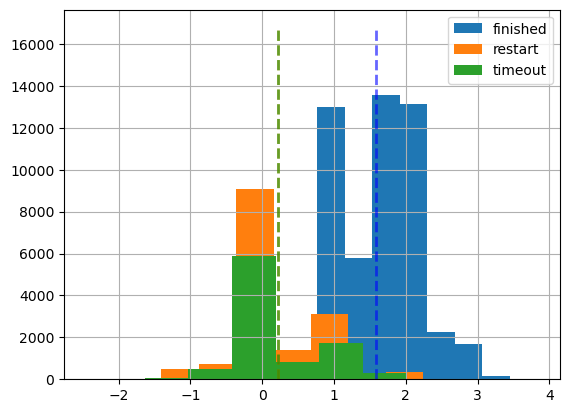

In [144]:
#For each run
scored_paths_all = processed_paths_all[processed_paths_all['score']!=-np.inf]
scored_paths_all.groupby('type')['score'].hist(legend = True)
mean_finished = scored_paths_all.groupby('type')['score'].mean()[0]
mean_restart = scored_paths_all.groupby('type')['score'].mean()[1]
mean_timeout = scored_paths_all.groupby('type')['score'].mean()[2]
y_limit = 14000
plt.vlines(mean_finished, 0, y_limit*1.2, ls='--',alpha = 0.6, color='blue', linewidth=2, label = 'mean fin.')
plt.vlines(mean_restart, 0, y_limit*1.2, ls='--',alpha = 0.6, color='orange', linewidth=2, label = 'mean res.')
plt.vlines(mean_timeout, 0, y_limit*1.2, ls='--',alpha = 0.6, color='green', linewidth=2, label = 'mean tim.')

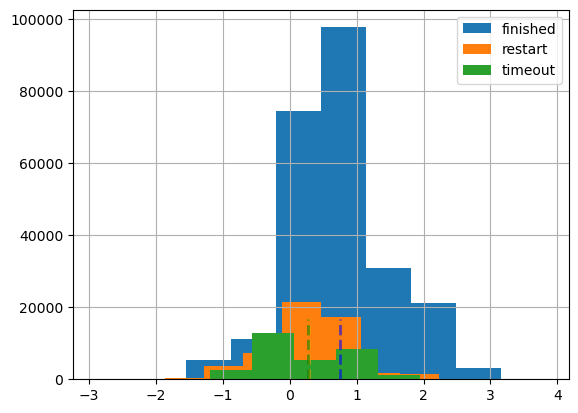

In [141]:
#Taking the score of every step in a game into consideration
scored_paths_all = dataset[dataset['score']!=-np.inf]
scored_paths_all = scored_paths_all[scored_paths_all['finished']==0]
scored_paths_all.groupby('type')['score'].hist(legend = True)
mean_finished = scored_paths_all.groupby('type')['score'].mean()[0]
mean_restart = scored_paths_all.groupby('type')['score'].mean()[1]
mean_timeout = scored_paths_all.groupby('type')['score'].mean()[2]
y_limit = 100000
plt.vlines(mean_finished, 0, y_limit*1.2, ls='--',alpha = 0.6, color='blue', linewidth=2, label = 'mean fin.')
plt.vlines(mean_restart, 0, y_limit*1.2, ls='--',alpha = 0.6, color='orange', linewidth=2, label = 'mean res.')
plt.vlines(mean_timeout, 0, y_limit*1.2, ls='--',alpha = 0.6, color='green', linewidth=2, label = 'mean tim.')

In [134]:
#The same function was used in our Homework 1
def bootstrap_CI(data, nbr_draws, with_means = False, mean=True):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices]
        
        if mean:
            means[n] = np.nanmean(data_tmp)
        else:
            means[n] = np.nansum(data_tmp) #.sum() mode if argument mean == False.
    if with_means :
        return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)], means
    else : 
        return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

Text(0, 0.5, 'Chance to Win the game')

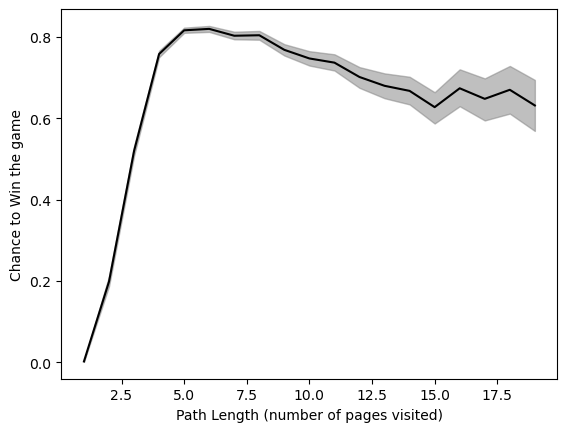

In [135]:
#Filter out the pathLength that has insufficient samples (less than 200)
dfd = processed_paths_all.groupby('pathLength').size()
path_length_list = list(dfd[dfd>200].index)

_paths_ = processed_paths_all[processed_paths_all['pathLength'].isin(path_length_list)].copy()

#Add an extra column for the sake of calculation
_paths_['is_successful'] = _paths_['type'].apply(lambda x: 1 if x == 'finished' else 0)

#Bootstrapping samples
df_plot = _paths_.groupby('pathLength').apply(lambda x: pd.concat(
    [pd.Series({
        'avg_is_continue': x['is_successful'].mean(),
        'lower_err_avg_is_continue': bootstrap_CI(x['is_successful'], 1000)[0],
        'upper_err_avg_is_continue': bootstrap_CI(x['is_successful'], 1000)[1]})]))

#Plot
plt.fill_between(df_plot.index,
                 df_plot['lower_err_avg_is_continue'] ,
                 df_plot['upper_err_avg_is_continue'], 
                 alpha = 0.5, color = 'gray')
plt.plot(df_plot['avg_is_continue'], color = 'black', label=path_length_list)

plt.xlabel('Path Length (number of pages visited)')
plt.ylabel('Chance to Win the game')

Text(0, 0.5, 'Chance to Continue playing the next run')

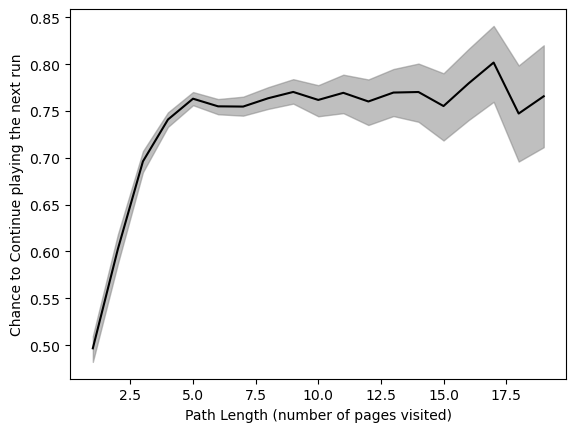

In [58]:
#Filter out the pathLength that has insufficient samples (less than 200)
dfd = processed_paths_all.groupby('pathLength').size()
path_length_list = list(dfd[dfd>200].index)

_paths_ = processed_paths_all[processed_paths_all['pathLength'].isin(path_length_list)].copy()

#Add an extra column for the sake of calculation
_paths_['is_continue'] = _paths_['bh_type'].apply(lambda x: 1 if x == 'continue' else 0)

#Bootstrapping samples
df_plot = _paths_.groupby('pathLength').apply(lambda x: pd.concat(
    [pd.Series({
        'avg_is_continue': x['is_continue'].mean(),
        'lower_err_avg_is_continue': bootstrap_CI(x['is_continue'], 1000)[0],
        'upper_err_avg_is_continue': bootstrap_CI(x['is_continue'], 1000)[1]})]))

#Plot
plt.fill_between(df_plot.index,
                 df_plot['lower_err_avg_is_continue'] ,
                 df_plot['upper_err_avg_is_continue'], 
                 alpha = 0.5, color = 'gray')
plt.plot(df_plot['avg_is_continue'], color = 'black', label=path_length_list)

plt.xlabel('Path Length (number of pages visited)')
plt.ylabel('Chance to Continue playing the next run')

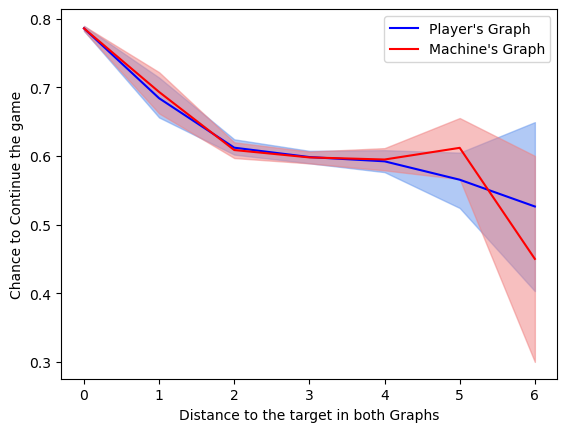

In [12]:
#Filter out the P_dist_to_target that has insufficient samples (less than 50)
dfd1 = processed_paths_all.groupby('P_dist_to_target').size()
dfd2 = processed_paths_all.groupby('M_dist_to_target').size()
dist_list1 = list(dfd1[dfd1>50].index)
dist_list2 = list(dfd2[dfd2>50].index)
dist_list = list((set(dist_list1) & set(dist_list2))-set([np.inf]))

_paths_ = processed_paths_all[np.array(processed_paths_all['P_dist_to_target'].isin(dist_list)) 
                              & np.array(processed_paths_all['M_dist_to_target'].isin(dist_list))].copy()

#Add an extra column for the sake of calculation
_paths_['is_continue'] = _paths_['bh_type'].apply(lambda x: 1 if x == 'continue' else 0)

#Bootstrapping samples
df_plot_P = _paths_.groupby('P_dist_to_target').apply(lambda x: pd.concat(
    [pd.Series({
        'avg_is_continue': x['is_continue'].mean(),
        'lower_err_avg_is_continue': bootstrap_CI(x['is_continue'], 1000)[0],
        'upper_err_avg_is_continue': bootstrap_CI(x['is_continue'], 1000)[1]})]))

df_plot_M = _paths_.groupby('M_dist_to_target').apply(lambda x: pd.concat(
    [pd.Series({
        'avg_is_continue': x['is_continue'].mean(),
        'lower_err_avg_is_continue': bootstrap_CI(x['is_continue'], 1000)[0],
        'upper_err_avg_is_continue': bootstrap_CI(x['is_continue'], 1000)[1]})]))
#Plot
plt.fill_between(df_plot_P.index,
                 df_plot_P['lower_err_avg_is_continue'] ,
                 df_plot_P['upper_err_avg_is_continue'], 
                 alpha = 0.5, color = 'cornflowerblue')
plt.plot(df_plot_P['avg_is_continue'], color = 'blue', label='Player\'s Graph')

plt.fill_between(df_plot_M.index,
                 df_plot_M['lower_err_avg_is_continue'] ,
                 df_plot_M['upper_err_avg_is_continue'], 
                 alpha = 0.5, color = 'lightcoral')
plt.plot(df_plot_M['avg_is_continue'], color = 'red', label='Machine\'s Graph')

plt.xlabel('Distance to the target in both Graphs')
plt.ylabel('Chance to Continue the game')
plt.legend()

## Export Features

In [187]:
features = processed_paths_all[['path_id','score']]
features = features.set_index('path_id')
features.sort_index()

,score
path_id,
0,1.950061
1,1.950061
2,1.624683
3,1.000000
4,1.390643
...,...
76188,0.603217
76189,0.000000
76190,1.000000


In [188]:
import pickle
pickle.dump(features, open( "data/features2.csv", "wb" ))